# Low carbon transition in electricity generation (2020)


Based on the dataset published by BP:
https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html

In [1]:
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path
import pandas as pd

In [2]:
BP_DATA_URL = ("https://www.bp.com/content/dam/bp/business-sites/en/"
               "global/corporate/xlsx/energy-economics/statistical-review/"
               "bp-stats-review-2020-all-data.xlsx")

BP_DATA_FILENAME = Path(BP_DATA_URL.rsplit("/", 1)[1])

In [3]:
if not BP_DATA_FILENAME.exists():
    print(f"Downloading data from: {BP_DATA_URL}")
    urlretrieve(BP_DATA_URL, BP_DATA_FILENAME)
else:
    print(f"Reusing local copy of {BP_DATA_FILENAME}")

Reusing local copy of bp-stats-review-2020-all-data.xlsx


In [4]:
POWER_GENERATION_SHEETS = {
    "geo_biomass_other": "Geo Biomass Other - TWh",
    "nuclear": "Nuclear Generation - TWh",
    "hydro": "Hydro Generation - TWh",
    "wind": "Wind Generation -TWh",
    "solar": "Solar Generation - TWh",
    "oil": "Elec Gen from Oil",
    "gas": "Elec Gen from Gas",
    "coal": "Elec Gen from Coal",
}

In [5]:
raw_data_sheets = {
    source: pd.read_excel(BP_DATA_FILENAME, skiprows=2, sheet_name=sheet_name)
    for source, sheet_name in POWER_GENERATION_SHEETS.items()
}

In [6]:
def preprocess_sheet(df):
    df.columns = [str(c).strip() for c in df.columns]
    df = (
        df
        .rename(columns={"Terawatt-hours": "country"})
        .query("not country.isnull()")
        .set_index("country")
        .filter(regex=r"^\d\d\d\d$", axis="columns")
    )
    df.columns = [int(c) for c in df.columns]
    return df.T

In [7]:
data_sheets = {
    source: preprocess_sheet(df)
    for source, df in raw_data_sheets.items()
}

In [8]:
data_sheets["non_hydro_re"] = (
    data_sheets["solar"]
    + data_sheets["wind"]
    + data_sheets["geo_biomass_other"]
)

In [9]:
data_sheets["low_carbon"] = (
    data_sheets["hydro"]
    + data_sheets["non_hydro_re"]
    + data_sheets["nuclear"]
)

In [10]:
data_sheets["fossil"] = (
    data_sheets["oil"]
    + data_sheets["gas"]
    + data_sheets["coal"]
)

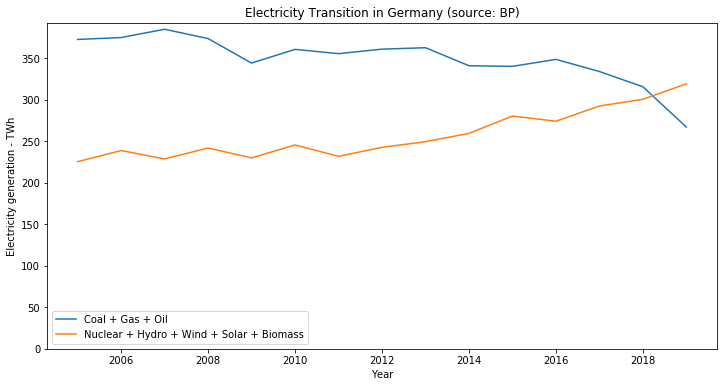

In [11]:
def plot_electricity_transition(country, start_year=2005, group_fossil=True, group_low_carbon=True):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set(
        xlabel="Year",
        ylabel="Electricity generation - TWh",
        title=f"Electricity Transition in {country} (source: BP)")
    if group_fossil:
        data_sheets["fossil"] .loc[start_year:, country].plot(label="Coal + Gas + Oil")
    else:
        for source in ["coal", "gas", "oil"]:
            data_sheets[source] .loc[start_year:, country].plot(label=source.title())
        
    if group_low_carbon:
        data_sheets["low_carbon"] .loc[start_year:, country].plot(
            label="Nuclear + Hydro + Wind + Solar + Biomass")
    else:
        for source in ["nuclear", "hydro", "wind", "solar", "geo_biomass_other"]:
            data_sheets[source] .loc[start_year:, country].plot(
                label=source.replace("_", " / ").title())
    ax.legend()
    ax.set_ylim(bottom=0)
    
    
plot_electricity_transition("Germany", group_fossil=True, group_low_carbon=True)

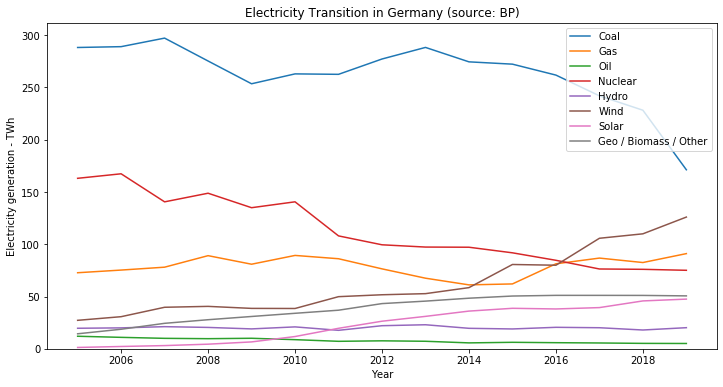

In [12]:
plot_electricity_transition("Germany", group_fossil=False, group_low_carbon=False)

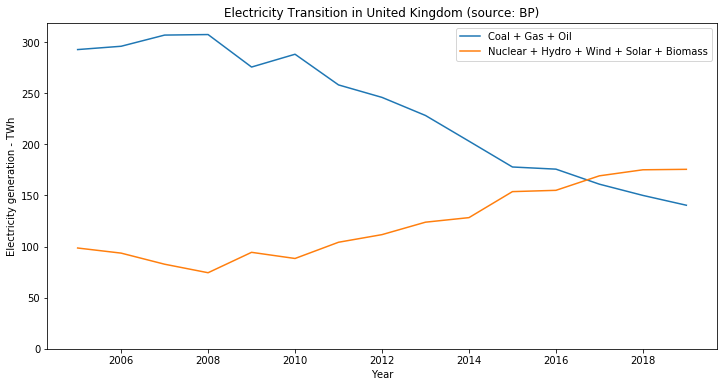

In [13]:
plot_electricity_transition("United Kingdom")

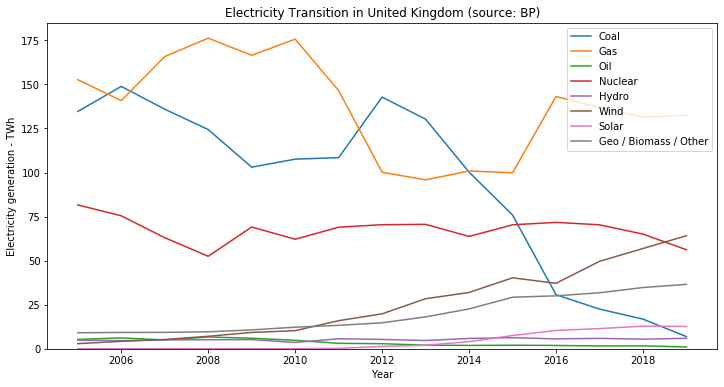

In [14]:
plot_electricity_transition("United Kingdom", group_fossil=False, group_low_carbon=False)

Low carbon electricity transition is happening quite fast in the UK. It took more time to actually start in Germany because of the decision to progressively shutdown nuclear before shutting down fossil fuels but is happening and accelerating since the last couple of years. In particular coal generation is collapsing and wind + solar are growing. There is still a lot of room to go to catch-up with hydro-dominated or nuclear + hydro dominated grids (e.g. Norway, Sweden and France).

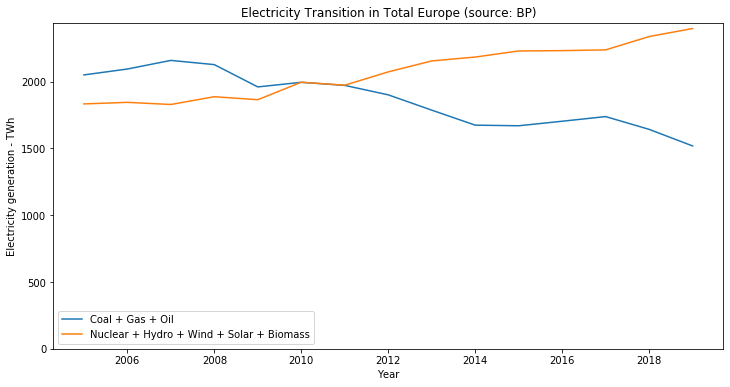

In [15]:
plot_electricity_transition("Total Europe")

Electricity transition is well under way and possibly accelerating in Europe, probably because of carbon pricing but still a lot of room for improvement :(

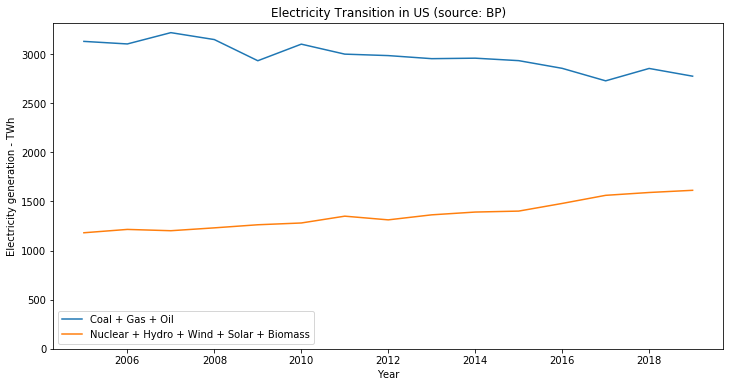

In [16]:
plot_electricity_transition("US")

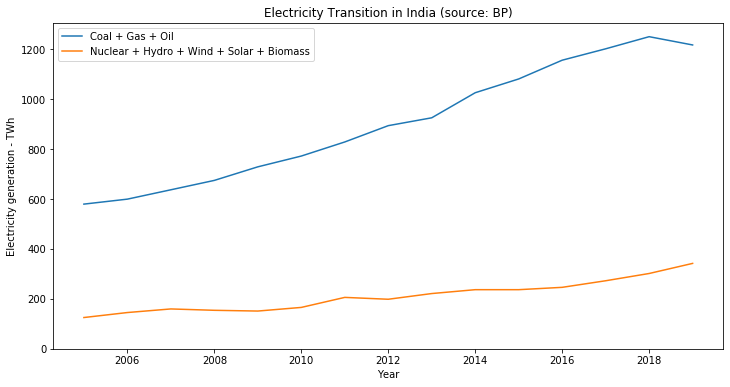

In [17]:
plot_electricity_transition("India")

Transition in the US has started for a long time but is very slow to happen. In India it seems to have started only very recently (2019).

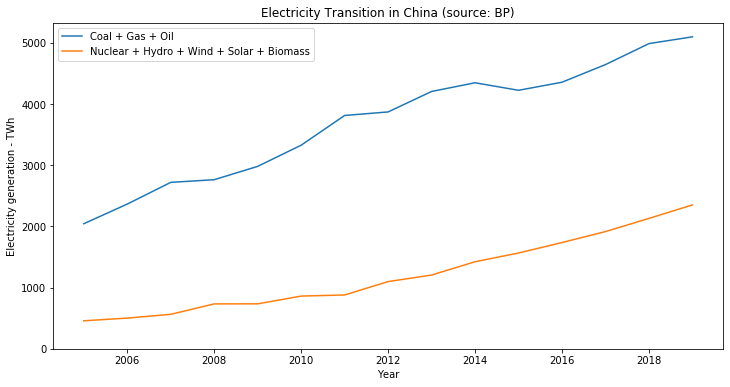

In [18]:
plot_electricity_transition("China")

The transition in China has not started despite significant increase in low carbon electricity generation: fossil fuel based electricity is still growing and growing fast...

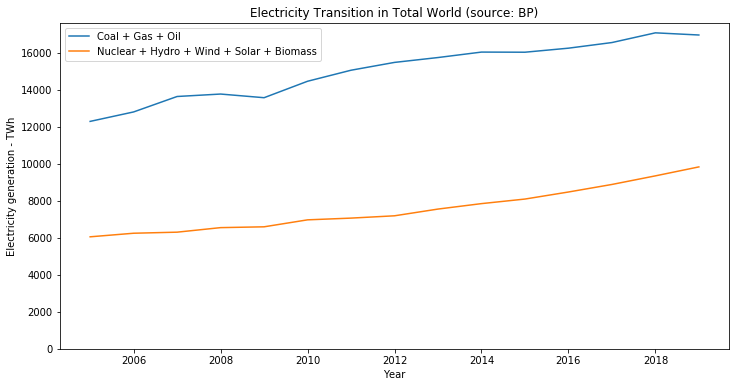

In [19]:
plot_electricity_transition("Total World")

Conclusion: at the world level we cannot really say that the low carbon transition has really started as fossil fuel based electrictiy generation was still increasing up to 2018 :(

## Speed of recent low carbon transition in Germany and the UK vs France in the 80s

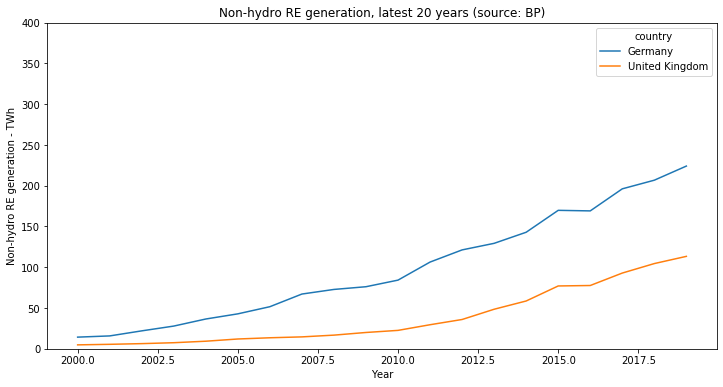

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(
    xlabel="Year",
    ylim=(0, 400),
    ylabel="Non-hydro RE generation - TWh",
    title="Non-hydro RE generation, latest 20 years (source: BP)")
data_sheets["non_hydro_re"].loc[2000:2020, ["Germany", "United Kingdom"]].plot(ax=ax);

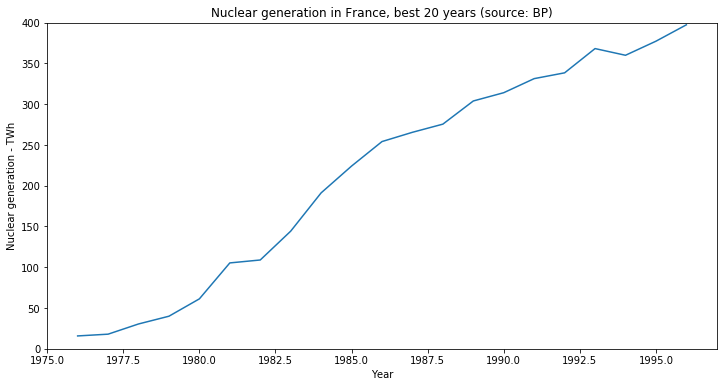

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(
    xlabel="Year",
    ylim=(0, 400),
    ylabel="Nuclear generation - TWh",
    title="Nuclear generation in France, best 20 years (source: BP)")
data_sheets["nuclear"].loc[1976:1996, "France"].plot(ax=ax);

Conclusion: non-hydro RE-based decarbonization in Germany and the UK is quite fast but still at least twice as slower than Nuclear-based transition in France in the 80s.